# Example notebook: Loading a simulation from the Fisher dataset

Authors: Adélie Gorce & Sambit Giri

In this notebook, we give an example of how to load one of the simulation lightcone from the dataset and turn it into an observational lightcone including thermal noise and beam smoothing, for the AA* layout, with the help of `tools21cm`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck18 as cos
from astropy import units, constants
# For noise calculations
import tools21cm as t2c

In [2]:
seed = 123456 # Choose your favorite number
np.random.seed(seed)

## Load metadata and simulation

In [3]:
# Folder containing the simulations
# ddir = '/data/cluster/agorce/SKA_chapter_simulations/'
ddir = './SKA_chapter_simulations/' # This folder can be created inside the repository folder. It will be ignored during the git commit.
# File with fiducial lightcone
file = ddir+'Lightcone_FID_400_Samples.h5'

In [4]:
# pick realisation to load
i = np.random.randint(400)

In [5]:
# Read h5py file to obtain metadata
with h5py.File(file, 'r') as f:
    frequencies = f['frequencies'][...]  # frequencies along the lightcone
    redshifts = f['redshifts'][...]  # redshifts along the lightcone
    box_length = float(f['box_length'][0])  # Mpc
    ngrid = int(f['ngrid'][0])  # number of pixels along the sky patch
    nrand = int(f['nrealisations'][0])  # number of realisations for a given parameter set
    lc = f['brightness_lightcone'][i, ...]
nfreq = frequencies.size
print(f'Lightcone runs from z={redshifts.min():.2f} to z = {redshifts.max():.2f}, mean redshift {np.mean(redshifts):.2f}.')
# move los axis to match t2c
lc = np.moveaxis(lc, 0, 2)

Lightcone runs from z=8.82 to z = 9.33, mean redshift 9.07.


In [6]:
# The physical length along the line-of-sight (LoS) is different from the field-of-view (FoV).
# Below the list box_length_list should be provided to power spectrum calculator of tools21cm to take this into account.
cdists = cos.comoving_distance(redshifts)
box_length_los = (cdists.max()-cdists.min()).value
box_length_list = [box_length, box_length, box_length_los]

print(f'Box length = {box_length} (FoV) and {box_length_los} (LoS) Mpc.')

Box length = 200.0 (FoV) and 126.46180362562882 (LoS) Mpc.


In [7]:
# Pick a random redshift for plots
iz = np.random.randint(nfreq)

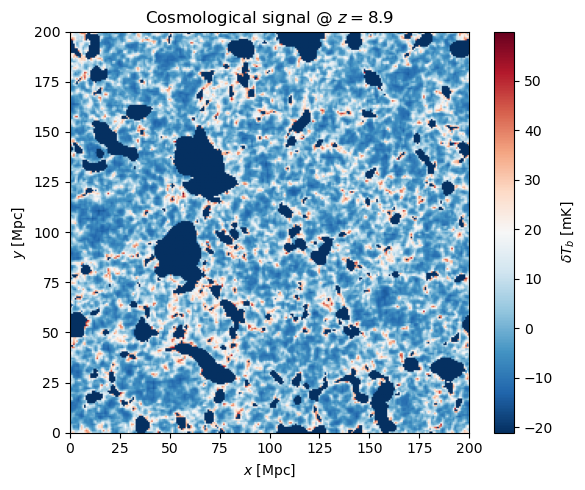

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    t2c.subtract_mean_signal(lc, los_axis=2)[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto',
    # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Cosmological signal @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

## Apply SKA AA* observational effects

This is the procedure also followed in `compute_statistic`. We compute noise maps for 1000 hours observations, split into 10 seconds intervals, 6 hours a day.

In [9]:
# SKA obs parameters
obs_time = 1000.  # hours
int_time = 10.  # seconds
total_int_time = 6.  # hours per day
declination = -30.0  # declination of the field in degrees
bmax = 2. * units.km  # km

Look at the $uv$ sampling for AA* layout 

AAstar contains 307 antennae.
ENU -> ECEF -> XYZ
Generating uv map from daily observations...


Gridding uv tracks: 100%|██████████| 2160/2160 [00:18<00:00, 118.46it/s]


...done


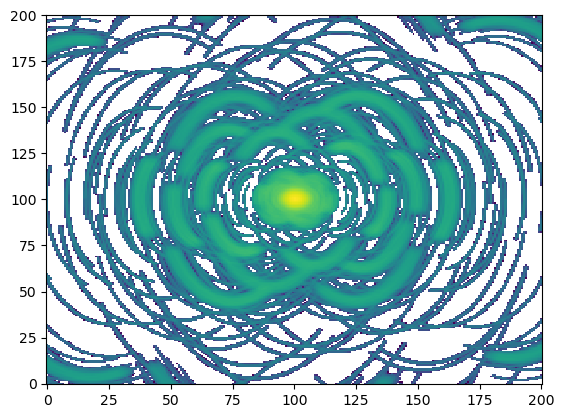

In [10]:
uv, Nant = t2c.get_uv_map(
                ncells=ngrid,                  # The number of cell used to make the image
                z=np.mean(redshifts),          # Redhsift of the slice observed
                subarray_type="AAstar",        # SKA layout
                total_int_time=total_int_time, # Observation per day in hours.
                int_time=int_time,             # Time period of recording the data in seconds.
                boxsize=box_length,            # Comoving size of the sky observed
                declination=declination,       # Declination angle defining the direction of observation
                )

x = np.linspace(0, box_length, ngrid)
plt.pcolormesh(x, x, np.log10(np.fft.fftshift(uv)))

In [11]:
# generate noise lightcone
noise_lc = t2c.noise_lightcone(
    ncells=ngrid,
    zs=redshifts,
    obs_time=obs_time,
    total_int_time=total_int_time,
    int_time=int_time,
    declination=declination,
    subarray_type="AAstar",
    boxsize=box_length,
    verbose=False,
    save_uvmap=ddir+'uvmap_AAstar.h5',  # save uv coverage to re-use for each realisation
    n_jobs=6,  # parallelisation
    checkpoint=16,  #  The code write data after checkpoint number of calculations.
)  # third axis is line of sight

Creating the uv maps.
...done
Creating noise...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


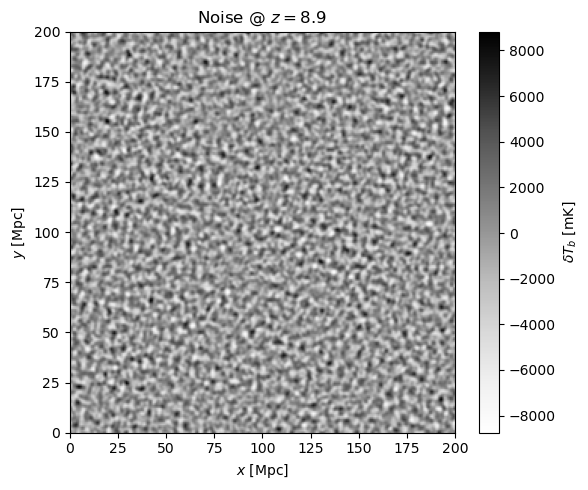

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    noise_lc[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='Greys', aspect='auto'
    )
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Noise @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

In [13]:
# combine noise and cosmological signal
noisy_lc = noise_lc + t2c.subtract_mean_signal(lc, los_axis=2)
# apply beam smoothing
dt_obs, zs_obs = t2c.smooth_lightcone(
    noisy_lc, 
    redshifts, 
    box_size_mpc=box_length,
    max_baseline=bmax,
)

100%|██████████| 128/128 [00:00<00:00, 158.77it/s]


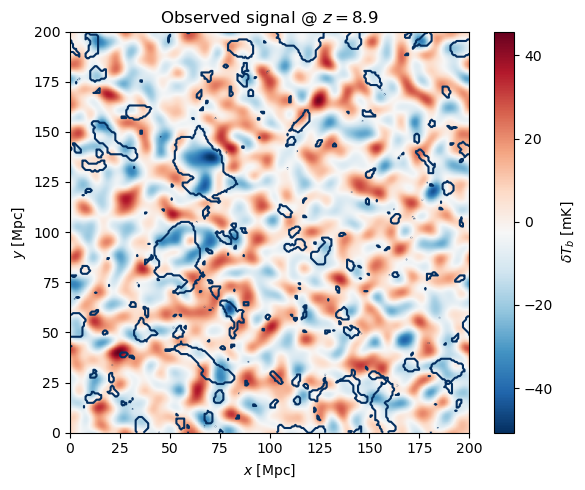

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(
    dt_obs[..., iz],
    extent=(0, box_length, 0, box_length),
    origin='lower', cmap='RdBu_r', aspect='auto',
    # vmin=-np.max(np.abs(lc[..., iz])), vmax=np.max(np.abs(lc[..., iz])),
    )
xi = np.linspace(0, box_length, ngrid)
ax.contour(xi, xi, lc[...,iz], levels=[1e-4], cmap="RdBu_r")
ax.set_xlabel(r'$x$ [Mpc]')
ax.set_ylabel(r'$y$ [Mpc]')
plt.colorbar(im, label=r'$\delta T_b$ [mK]')
ax.set_title(rf'Observed signal @ $z={redshifts[iz]:.1f}$')
fig.tight_layout()

## Power spectrum

In [15]:
# Power spectra
nbins = 15
k_nyquist = np.pi/box_length*ngrid
# Fiducial 
ps_clean, ks = t2c.power_spectrum_1d(lc, kbins=15, box_dims=box_length_list)
ps_obs, ks = t2c.power_spectrum_1d(dt_obs, kbins=15, box_dims=box_length_list)
ps_noise, ks = t2c.power_spectrum_1d(noise_lc, kbins=15, box_dims=box_length_list)

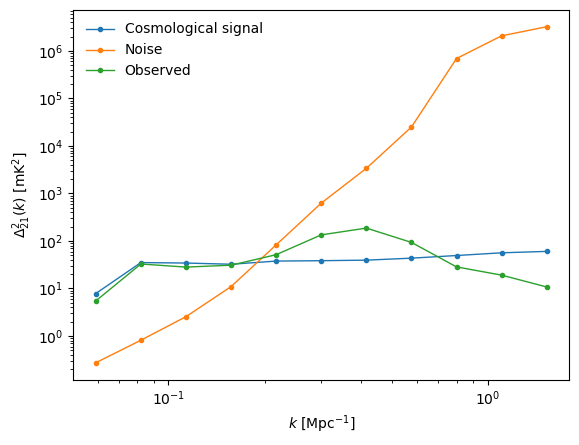

In [16]:
fig, ax = plt.subplots()
ax.loglog(ks[ks<k_nyquist/2], ps_clean[ks<k_nyquist/2]*ks[ks<k_nyquist/2]**3/2/np.pi**2, lw=1., marker='.', label='Cosmological signal')
ax.loglog(ks[ks<k_nyquist/2], ps_noise[ks<k_nyquist/2]*ks[ks<k_nyquist/2]**3/2/np.pi**2, lw=1., marker='.', label='Noise')
ax.loglog(ks[ks<k_nyquist/2], ps_obs[ks<k_nyquist/2]*ks[ks<k_nyquist/2]**3/2/np.pi**2, lw=1., marker='.', label='Observed')
ax.set_ylabel(r'$\Delta^2_{21}(k)$ [mK$^2$]')
ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
plt.legend(frameon=False)
# plt.ylim(1e3, 1e8)